# 랭그래프로 간단한 챗봇 만들기

## 필요 라이브러리 설치

In [12]:
%pip install langgraph

Note: you may need to restart the kernel to use updated packages.


## GPT 모델 설정

In [13]:
from dotenv import load_dotenv
load_dotenv()

True

In [14]:
from langchain_openai import ChatOpenAI

# 모델 초기화
model = ChatOpenAI(model="gpt-4o-mini")
model.invoke('안녕하세요!')

AIMessage(content='안녕하세요! 어떻게 도와드릴까요?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 10, 'total_tokens': 20, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_eca0ce8298', 'id': 'chatcmpl-CiArY0KFHfI0Wg9LKyRN3SV8BWu2K', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='lc_run--470a2c3b-0c0d-4f4f-9a50-121674cdea90-0', usage_metadata={'input_tokens': 10, 'output_tokens': 10, 'total_tokens': 20, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

## 상태 정의
- `Annotated[T, func]`: 타입 T에 메타데이터나 동작을 추가할 때 사용
- `add_messages`: LangGraph가 제공하는 Reducer로 기존 메시지 리스트를 덮어쓰지않고 새로운 메시지를 리스트 뒤에 추가
  - `Reducer`? 함수형 프로그래밍에서 온 개념으로 기존 값과 새 값을 어떻게 합칠 것인가를 정의하는 함수

In [15]:
from typing import Annotated # annotated는 타입 힌트를 사용할 때 사용하는 함수
from typing_extensions import TypedDict # TypedDict는 딕셔너리 타입을 정의할 때 사용하는 함수

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

class State(TypedDict):
    """
    State 클래스는 TypedDict를 상속받습니다.

    속성:
        messages (Annotated[list[str], add_messages]): 메시지들은 "list" 타입을 가집니다.
       'add_messages' 함수는 이 상태 키가 어떻게 업데이트되어야 하는지를 정의합니다.
        (이 경우, 메시지를 덮어쓰는 대신 리스트에 추가합니다)
    """
    messages: Annotated[list[str], add_messages]



## 그래프 정의
- StateGraph를 생성할 때 상태의 스키마로 State 전달
- 그래프가 처리할 데이터의 형태를 정의

In [16]:
graph_builder = StateGraph(State)

## 챗봇 노드 함수 정의

In [17]:
def generate(state: State):
    """
    주어진 상태를 기반으로 챗봇의 응답 메시지를 생성합니다.

    매개변수:
    state (State): 현재 대화 상태를 나타내는 객체로, 이전 메시지들이 포함되어 있습니다.
		
    반환값:
    dict: 모델이 생성한 응답 메시지를 포함하는 딕셔너리. 
          형식은 {"messages": [응답 메시지]}입니다.
    """ 
    return {"messages": [model.invoke(state["messages"])]}


graph_builder.add_node("generate", generate) # 그래프에 노드 추가

## 엣지 정의 및 컴파일

In [18]:
graph_builder.add_edge(START, "generate")
graph_builder.add_edge("generate", END)    

graph = graph_builder.compile()

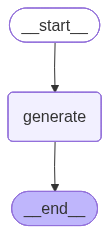

In [19]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception: 
    pass

## 그래프 실행
- 응답 메시지 : {'messages': [HumanMessage(...), AIMessage(...)]}

In [20]:
response = graph.invoke({"messages": ["안녕하세요! 저는 김정은입니다"]})

print(type(response))
response

<class 'dict'>


{'messages': [HumanMessage(content='안녕하세요! 저는 김정은입니다', additional_kwargs={}, response_metadata={}, id='544f972f-fb62-48f6-b11d-06e48fe5d713'),
  AIMessage(content='안녕하세요, 김정은님! 어떻게 도와드릴까요?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 15, 'prompt_tokens': 15, 'total_tokens': 30, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_b547601dbd', 'id': 'chatcmpl-CiAraGvrCDD9EhSM8AGVgry4oiJFz', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='lc_run--bcb9bd49-c3cd-481e-8021-b3b6b01c85d6-0', usage_metadata={'input_tokens': 15, 'output_tokens': 15, 'total_tokens': 30, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]

In [21]:
response["messages"].append("제 이름을 아시나요?")
graph.invoke(response)

{'messages': [HumanMessage(content='안녕하세요! 저는 김정은입니다', additional_kwargs={}, response_metadata={}, id='544f972f-fb62-48f6-b11d-06e48fe5d713'),
  AIMessage(content='안녕하세요, 김정은님! 어떻게 도와드릴까요?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 15, 'prompt_tokens': 15, 'total_tokens': 30, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_b547601dbd', 'id': 'chatcmpl-CiAraGvrCDD9EhSM8AGVgry4oiJFz', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='lc_run--bcb9bd49-c3cd-481e-8021-b3b6b01c85d6-0', usage_metadata={'input_tokens': 15, 'output_tokens': 15, 'total_tokens': 30, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}),

## 스트리밍 출력

In [22]:
inputs = {"messages": [("human", "한국과 일본의 관계에 대해 자세히 알려줘")]}
for chunk, _ in graph.stream(inputs, stream_mode="messages"):
    print(chunk.content, end="")

한국과 일본의 관계는 역사적으로 복잡하고 여러 가지 요소가 얽혀 있습니다. 아래는 한국과 일본의 관계의 주요 측면들을 정리한 내용입니다.

### 1. 역사적 배경
- **고대 및 중세**: 한일 관계는 고대부터 시작되었습니다. 일본은 한반도에서 오는 문화와 기술적 영향을 받아 발전했습니다. 신라, 고구려 등의 왕국과 일본의 초기 국가와의 관계가 있었습니다.
- **일제강점기 (1910-1945)**: 일본은 1910년부터 1945년까지 한국을 식민통치하였습니다. 이 시기는 한국인들에게 큰 고통과 상처를 남겼으며, 많은 한국인들이 강제노역, 징용, 위안부 문제 등으로 고통을 받았습니다. 이러한 역사적 사실은 한국과 일본의 관계에서 주요한 갈등 요인이 되고 있습니다.

### 2. 현대의 정치적 관계
- **외교 관계**: 한국과 일본은 1965년에 외교 관계를 정식으로 수립하였지만, 역사 문제, 영토 분쟁(예: 독도 문제), 위안부 문제 등으로 긴장이 지속되고 있습니다.
- **경제적 관계**: 두 나라는 경제적으로 서로 의존하고 있습니다. 일본은 한국의 주요 무역 파트너 중 하나이며, 많은 한국 기업들이 일본의 기술과 자원을 이용하고 있습니다.

### 3. 문화 및 사회적 교류
- **문화 교류**: 최근 몇 년간 K-pop과 한국 드라마의 인기로 인해 한국 문화가 일본에서 큰 인기를 끌고 있습니다. 또한 일본의 애니메이션과 만화도 한국에서 많은 팬을 보유하고 있습니다.
- **관광**: 한국과 일본 간의 관광도 활발하며, 서로의 국가를 방문하는 관광객 수가 꾸준히 증가하고 있습니다.

### 4. 현재의 갈등과 해결을 위한 노력
- **역사 문제**: 위안부, 강제징용 등의 문제에 대한 인식 차이로 인해 여전히 갈등이 존재합니다. 한국은 일본 정부의 사과와 배상을 요구하고 있지만, 일본 정부는 과거의 문제에 대한 입장을 다소 경직된 자세로 유지하고 있습니다.
- **영토 분쟁**: 독도(다케시마) 문제는 두 나라 간의 민감한 정치적 이슈 중 하나로, 각국